In [1]:
from fastai2.vision.all import *

# EDA

In [2]:
ls storage/

DanceData/  annotations/  data/  train2014.zip


In [3]:
path = Path('storage/DanceData/')
path.ls()

(#4) [Path('storage/DanceData/train.csv'),Path('storage/DanceData/test.csv'),Path('storage/DanceData/train'),Path('storage/DanceData/test')]

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


# Helper Functions

In [5]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [6]:
print('encoding result : ', encode_label('4'))
print('decoding result', decode_target(encode_label('4')))

encoding result :  tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
decoding result 4


# Datablock and Dataloaders

In [7]:
def get_x(r): return path/'train'/r['Image']
def get_y(r): return r['target']
dblock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    splitter=RandomSplitter(),
    get_x = get_x,
    get_y = get_y,
    item_tfms = Resize(224),
    batch_tfms=aug_transforms())

In [8]:
dls = dblock.dataloaders(df)

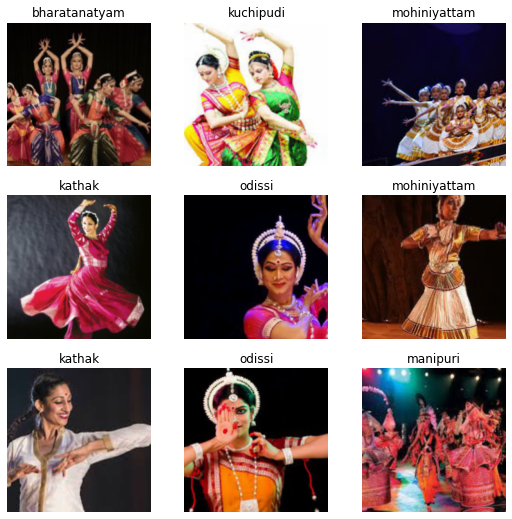

In [9]:
dls.show_batch()

# Accuracy Metrics

In [10]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

# Basic Model

In [11]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,3.516402,2.444814,0.375000,00:05


epoch,train_loss,valid_loss,accuracy,time
0,2.247205,1.482225,0.500000,00:05


# Predictions on single batch

In [12]:
xb, yb = dls.one_batch()
print(xb.shape, yb.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [13]:
preds, targets = learn.get_preds(dl=[(xb, yb)])

In [14]:
temp1 = preds.argmax(dim=1)
temp2 = yb.cpu()

In [15]:
from sklearn.metrics import f1_score
score = partial(f1_score, average='weighted')
score(temp1, temp2)

0.5685451369282891

# Prediction on test set

In [16]:
test = pd.read_csv('storage/DanceData/test.csv')
test.head()

,Image
0,508.jpg
1,246.jpg
2,473.jpg
3,485.jpg
4,128.jpg


In [17]:
test_dl = learn.dls.test_dl(test)

In [18]:
preds, targs = learn.get_preds(dl=test_dl)

In [19]:
predictions = preds.argmax(dim=1)

In [20]:
test['target'] = predictions
test.head()

,Image,target
0,508.jpg,3
1,246.jpg,2
2,473.jpg,5
3,485.jpg,1
4,128.jpg,4


In [21]:
test.to_csv('submission.csv',index=None)